* Autoencoders are pretty neat, but can we improve our models ability to understand the multi-dimensional space of our data?
    + In this notebook we'll play with `variational autoencoders` to get a better feel for how they work and understand how they improve upon our vanilla autoencoder

In [ ]:
#| echo: false
from data import *
from utils import *
from model import *
import pdb

In [ ]:
#| echo: false
plt.style.use('dark_background')

In [ ]:
#| echo: false
#| output: false
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dls, train_df, valid_df = get_data()

## Dataset

* Our dataset is MNIST
    + A selection of ~70,000 handwritten digits -- a few sampels can be seen below:

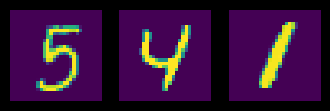

In [ ]:
#| echo: true
plot_dataset(train_df, num_samples=3)

In [ ]:
batch = next(iter(dls.train))
batch[0].to('cpu'); 
batch[1].to('cpu');
batch[0].shape

torch.Size([64, 1, 28, 28])

In [ ]:
#| echo: false
#| output: false
model = Vae(latent_dims=3,
           ).to('cuda')
model.to('cuda');
model_out = model(batch[0])
recon = model.generate(batch[0])
recon, zm, zv = model_out
recon.shape, zm.shape, zv.shape, batch[0].shape, recon.shape

(torch.Size([64, 1, 28, 28]),
 torch.Size([64, 3]),
 torch.Size([64, 3]),
 torch.Size([64, 1, 28, 28]),
 torch.Size([64, 1, 28, 28]))

In [ ]:
learner = Learner(dls, model, loss_func=FeatureLoss(cross_entropy=False))

In [ ]:
learner.fine_tune(12, 3e-2)

epoch,train_loss,valid_loss,time
0,5517.600586,5498.638184,00:09


epoch,train_loss,valid_loss,time
0,4891.000488,5152.509766,00:09
1,4193.120605,4459.402344,00:09
2,3492.046143,3789.639160,00:09
3,2972.184326,inf,00:09
4,2806.825684,3257.438721,00:09
5,2768.563477,9286.187500,00:09
6,2725.435791,3127.360596,00:09
7,2669.043701,3085.611572,00:09
8,2644.336670,3081.457764,00:09
9,2591.880371,3039.255615,00:09


## Reconstructed Images

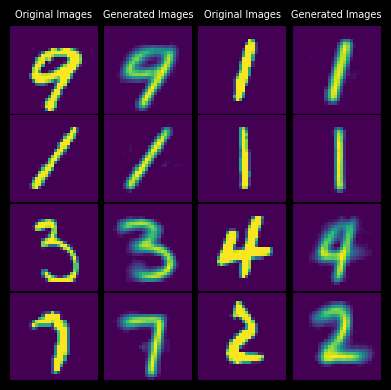

In [ ]:
#| echo: false
model.to('cuda');
plt_subs(*get_valid_results(model, dls.train), size=2)

## Latent space exploration

* Lets see how our validation set gets mapped into embedding space via our encoder
    + the model is able to map each number into it's own subspace -- some overlap considerably more than others
    + even for points outside the distribution that it's already seen, it is able to map them into something meaningful

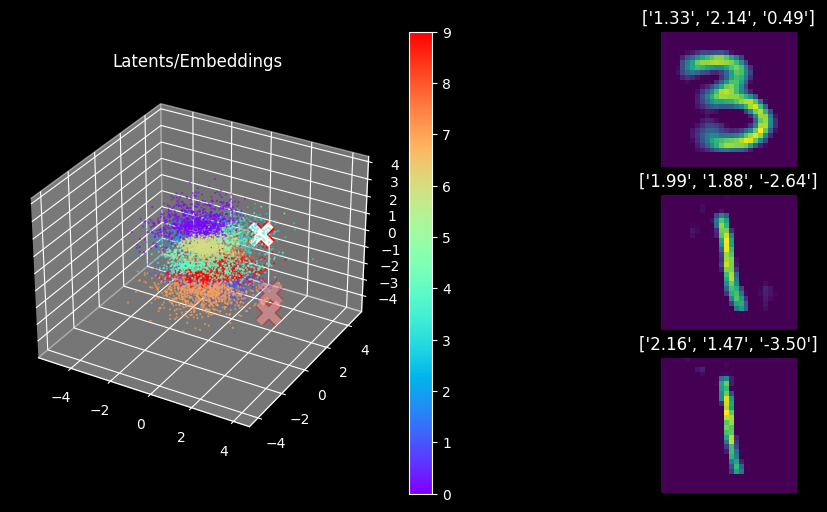

In [ ]:
#| fig-cap: "Figure 2: Embedding Space and Latent Reconstructions"
#| fig-subcap:
#|   - "left: embedding scatter plot <br> right: reconstructed latents"
plot_latent_regen(model, min=-3.5, max=3.5)